## Modifying Notebook display

In [1]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    .container#notebook-container    { width: 95%;}
    div#menubar-container     { width: 95%; }
    div#maintoolbar-container { width: 95%; }
</style>
<script>
    document.getElementById("notebook-container").style.margin = "auto";
</script>
"""))

## For running the notebook as Google Colab Instance

``
#mounting the google drive for accessing other necessary files
from google.colab import drive
drive.mount('/content/gdrive')
``

``
#Checking the available files in the "Colab Notebooks" folder of the google drive
!ls /content/gdrive/My\ Drive/Colab\ Notebooks/Handwritten\ Digit\ Recognition
``

``
import sys
``

``
#changing the current working directory to "Colab Notebooks" folder in the google drive
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/Handwritten Digit Recognition')
``

## For running the notebook as Kaggle Kernel

change directory to the dataset where our custom scripts are uploaded

> ``os.chdir("/kaggle/input/handwritten-digit-recognition")``

***handwritten-digit-recognition*** is simply a folder name. It can vary based on the dataset you create in kaggle while uploading the python scripts.


load custom module or files or dataset

> ``from  dataset import load_dataset, train_dev_split, prep_dataset`` <br>
> ```from dataset import visualize_data_distribution, visualize_dataset```


reset our working directory

> ```os.chdir("/kaggle/working/")```

**NOTE:** The ***input directory*** is Read-Only. So, we must switch back to the ***working directory*** for performing any other operation that requires write access. Make sure this note book runs as a part of the dataset you create as said above because all the custom modules are uploaded there. 


## Importing Dependencies

In [2]:
import time    #for calculating time
import os
#core packages
import numpy as np
import matplotlib.pyplot as plt

# os.chdir("/kaggle/input/handwritten-digit-recognition")

#custom module
from  dataset import load_dataset, train_dev_split, prep_dataset
from dataset import visualize_data_distribution, visualize_dataset

from ModelUtils import relu, relu_grad, softmax
from ModelUtils import rand_mini_batches, convert_time
from ModelUtils import confusion_matrix, plot_confusion_matrix, model_metrics, metric_summary
from ModelUtils import visualize_training_results, visualize_prediction, visualize_mislabelled_images
from ModelUtils import save_model, load_model

from dataAugmentation import data_generator

from ffnn import *

# # reset our working directory
# os.chdir("/kaggle/working/")

np.random.seed(1)
%matplotlib inline

## Dataset Preparation

### Loading Dataset

In [3]:
dataset_size_in_per = 50

train_x_orig, train_y_orig, test_x_orig, test_y_orig = load_dataset(dataset = "mnist", size_in_per = dataset_size_in_per)

print("Sample Size : %d%%\n"%(dataset_size_in_per))
print("Data\t\t\t","Datatype\t\t","Dataset Size")
print("=================================================================")
print("Training Set Images:\t" + str(type(train_x_orig))+"\t",str(train_x_orig.shape))
print("Training Set Labels:\t" + str(type(train_y_orig))+"\t",str(train_y_orig.shape))
print("Test Set Images:\t" + str(type(test_x_orig))+"\t",str(test_x_orig.shape))
print("Test Set Labels:\t" + str(type(test_y_orig))+"\t",str(test_y_orig.shape))
print("=================================================================")



Sample Size : 50%

Data			 Datatype		 Dataset Size
Training Set Images:	<class 'numpy.ndarray'>	 (30000, 28, 28)
Training Set Labels:	<class 'numpy.ndarray'>	 (30000, 1)
Test Set Images:	<class 'numpy.ndarray'>	 (5000, 28, 28)
Test Set Labels:	<class 'numpy.ndarray'>	 (5000, 1)


### Train-Dev set Split

In [4]:
train_x_split, train_y_split, dev_x_split, dev_y_split = train_dev_split(train_x_orig, train_y_orig)

print("Data\t\t\t\t","Datatype\t\t","Shape")
print("========================================================================")
print("Training Set Images:\t\t" + str(type(train_x_split))+"\t",str(train_x_split.shape))
print("Training Set Labels:\t\t" + str(type(train_y_split))+"\t",str(train_y_split.shape))
print("Development Set Images:\t\t" + str(type(dev_x_split))+"\t",str(dev_x_split.shape))
print("Development Set Labels:\t\t" + str(type(dev_y_split))+"\t",str(dev_y_split.shape))
print("========================================================================")


Data				 Datatype		 Shape
Training Set Images:		<class 'numpy.ndarray'>	 (25000, 28, 28)
Training Set Labels:		<class 'numpy.ndarray'>	 (25000, 1)
Development Set Images:		<class 'numpy.ndarray'>	 (5000, 28, 28)
Development Set Labels:		<class 'numpy.ndarray'>	 (5000, 1)


### Visualizing Data Distribution

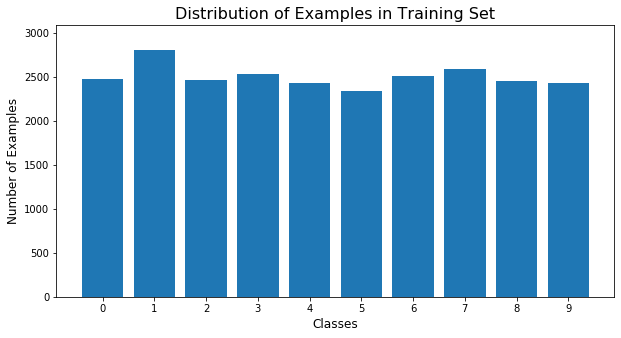

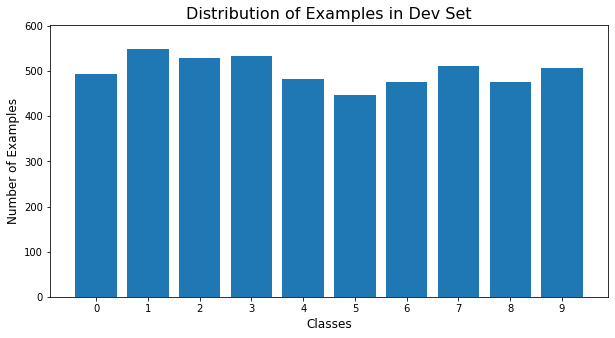

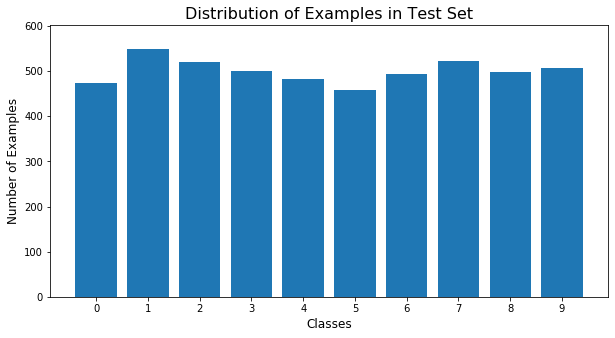

In [5]:
visualize_data_distribution(train_y_split, dataset_type = "training")
visualize_data_distribution(dev_y_split,  dataset_type = "dev")
visualize_data_distribution(test_y_orig,  dataset_type = "test")

### Visualizing Dataset

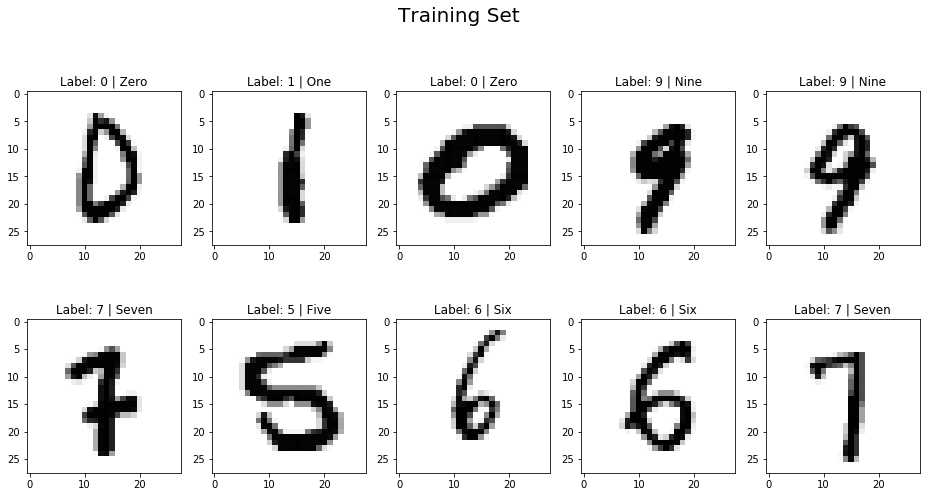

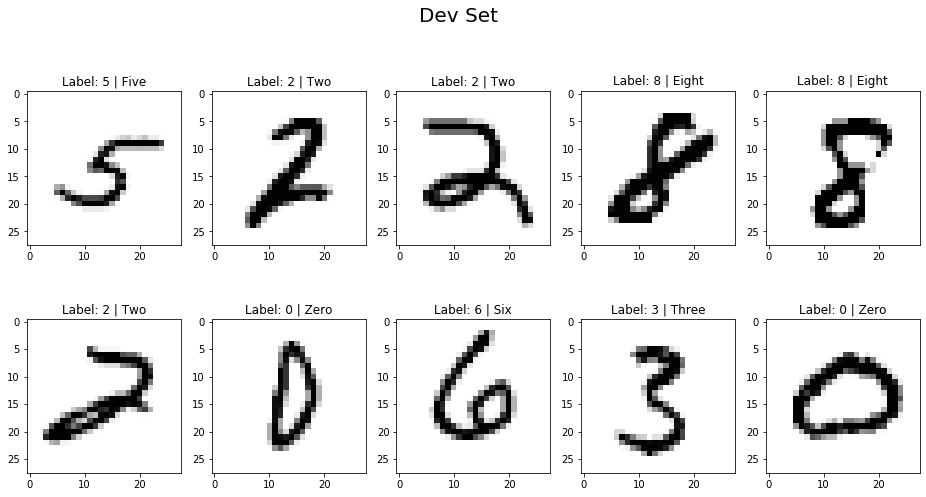

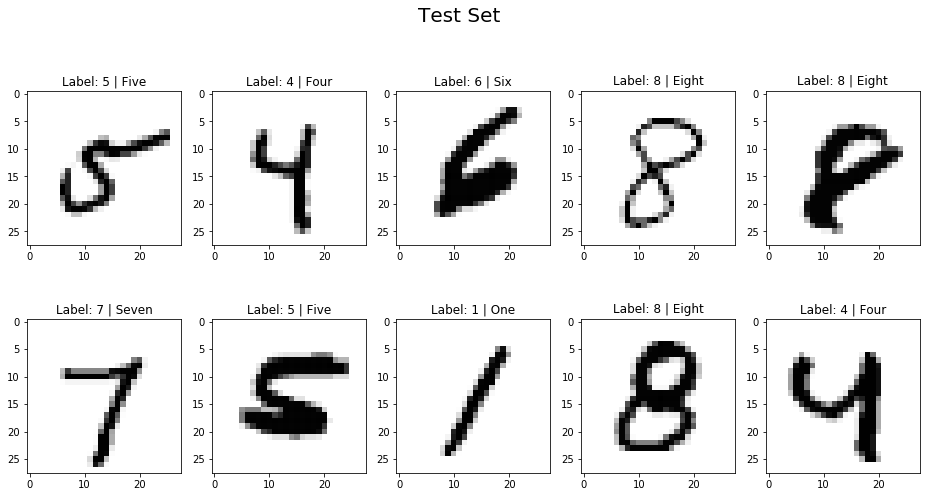

In [6]:
visualize_dataset(train_x_split, train_y_split, dataset = "mnist", dataset_type = "training")
visualize_dataset(dev_x_split, dev_y_split, dataset = "mnist", dataset_type = "dev")
visualize_dataset(test_x_orig, test_y_orig, dataset = "mnist", dataset_type="test")

### Preparing Dataset

In [7]:
train_x_norm, train_y_encoded = prep_dataset(train_x_split, train_y_split, num_class = 10)
dev_x_norm, dev_y_encoded= prep_dataset(dev_x_split, dev_y_split, num_class = 10)
test_x_norm, test_y_encoded = prep_dataset(test_x_orig, test_y_orig, num_class = 10)

print("Data\t\t\t","Before Processing\t","After Processing")
print("=================================================================")
print("Training Set Images:\t" + str(train_x_split.shape)+"\t\t"+ str(train_x_norm.shape))
print("Training Set Labels:\t" + str(train_y_split.shape)+"\t\t"+ str(train_y_encoded.shape))
print("Dev Set Images:\t\t" + str(dev_x_split.shape)+"\t\t"+ str(dev_x_norm.shape))
print("Dev Set Labels:\t\t" + str(dev_y_split.shape)+"\t\t"+ str(dev_y_encoded.shape))
print("Test Set Images:\t" + str(test_x_orig.shape)+"\t\t"+ str(test_x_norm.shape))
print("Test Set Labels:\t" + str(test_y_orig.shape)+"\t\t"+ str(test_y_encoded.shape))
print("=================================================================")


Data			 Before Processing	 After Processing
Training Set Images:	(25000, 28, 28)		(784, 25000)
Training Set Labels:	(25000, 1)		(10, 25000)
Dev Set Images:		(5000, 28, 28)		(784, 5000)
Dev Set Labels:		(5000, 1)		(10, 5000)
Test Set Images:	(5000, 28, 28)		(784, 5000)
Test Set Labels:	(5000, 1)		(10, 5000)


In [8]:
def learning_rate_scledule(alpha_prev, epoch, decay_rate = 1 ):
    alpha = (1/(1 + decay_rate * epoch)) * alpha_prev
    
    return alpha

In [9]:
# # [0.000338,0.003378]
# lr = 0.003378
# epochs = 100
# decay_rate = 0.05
# step_decay = 1
# for i in range(epochs):
#     if i%step_decay == 0:
#         decay_rate = lr / ((i+1)/epochs)
#         lr = learning_rate_scledule(lr, i, decay_rate)
        
#         if lr <= 0.000338 :
#             lr = 0.000338 
#         print("%d \t%.8f  %.8f"%(i,decay_rate, lr))

### Train Model

In [16]:
# Final Model Training

def train(X_train, Y_train, X_dev, Y_dev, layers_dim, hyperParams, initialization = "random", optimizer = 'bgd',regularizer = None, verbose = 3, patience = None, step_decay = None):
    # loading the hyper parameters
    learning_rate = hyperParams['learning_rate']
    num_epoch = hyperParams['num_epoch']
    b1 = hyperParams['beta1']
    b2 = hyperParams['beta2']
    ep = hyperParams['epsilon']
    lambd = hyperParams['lambda']
    keep_probs = hyperParams['keep_probs']

    #setting up necessary variables for early stopping
    if patience != None and patience !=0:
        path = "temp/" # pats to save the intermediate best parameters
        if not os.path.exists(path):
            os.makedirs(path)
        filename = "best_param_intermediate"

        early_stop_count = 0 #for early stopping
        max_val_acc = 0 # for keeping track of maximum validation accuracy
    
    #initializing the variables
    seed = 1
    m = Y_train.shape[1]
    train_accs = []  # keep track of training accuracy
    val_accs = []     # keep track of Validation accuracy
    train_losses = []  # keep track of training loss
    val_losses = []     # keep track of Validation loss
    
    #selecting the minibatch size for each optimizer
    if optimizer == 'sgd':
        mini_batch_size = 1
    elif optimizer == 'bgd':
        mini_batch_size = m
    elif optimizer == 'mgd' or optimizer == 'adam':
        mini_batch_size = hyperParams['mini_batch_size']
    else:
        raise ValueError("Optimizer value out of scope")
        
    #initializing the model parameters
    parameters = init_parameters(layers_dim, initialization)
    
    #initializing adam parameters, used only when optimizer = 'adam'
    t = 0
    v,s = initialize_adam(parameters)
    
    train_toc = time.time() # for calculating entire training time
    print("Training The Model...")
    
    #Gradient Descent begins
    for i in range(num_epoch):
        seed += 1
        time_trained = 0
        batch_times = []
        accs = []
        losses = []
        
        if step_decay!= None and step_decay!= 0:
            if i%step_decay == 0:
                decay_rate = learning_rate / ((i+1)/num_epoch)
                learning_rate = learning_rate_scledule(learning_rate, i, decay_rate)
                if learning_rate <= 0.000338: learning_rate = 0.000338 
        
        
        if verbose > 0:
            print("\nEpoch %d/%d: learning rate - %.6f"%(i+1,num_epoch,learning_rate))
        
        minibatches = rand_mini_batches(X_train, Y_train, mini_batch_size, seed)
        total_minibatches = len(minibatches)
        
        for ind, minibatch in enumerate(minibatches):
            batch_toc = time.time() # for calculating time of an epoch cycle
            
            #retriving minibatch of X and Y from training set
            (minibatch_X, minibatch_Y) = minibatch
            
            #forward Propagation
            AL, caches, dropout_masks = forward_prop(minibatch_X, parameters, keep_probs = keep_probs, regularizer = regularizer)
            
            #Computing cross entropy cost
            cross_entropy_cost = softmax_cross_entropy_cost(AL, minibatch_Y, caches, lambd = lambd, regularizer = regularizer, from_logits = True) #accumulating the batch costs
            
            #Backward Propagation
            grads = backward_prop(AL, minibatch_Y, caches, dropout_masks = dropout_masks, keep_probs = keep_probs, lambd = lambd, regularizer = regularizer)
                
            #Updating parameters
            t += 1
            parameters, v, s = update_parameters(parameters, grads, learning_rate, optimizer = optimizer, beta1 = b1, beta2 = b2,  epsilon = ep, v = v, s = s, t = t)
            
            # Calculating training time for each batch 
            batch_tic = time.time()
            batch_times.append(batch_tic - batch_toc)
            time_trained = np.sum(batch_times)
            
            #calculating training progress
            per = ((ind+1) / total_minibatches) * 100
            inc = int(per // 10) * 2
            
            #calculating accuracy and loss of the training batch
            acc,loss = evaluate(minibatch_X, minibatch_Y, parameters)
            accs.append(acc)
            losses.append(loss)
            
            #averaging all the accs and losses till now
            train_acc = np.mean(accs)
            train_loss = np.mean(losses)
            
            #Verbosity 0: Silent mode
            #Verbosity 1: Epoch mode
            #Verbosity 2: Progress bar mode
            #Verbosity 3 or greater: Metric mode
                
            if verbose == 2:
                print ("%d/%d [%s>%s %.0f%%] - %.2fs"%(ind+1, total_minibatches, '=' * inc,'.'*(20-inc), per, time_trained),end='\r')
            elif verbose > 2:
                print ("%d/%d [%s>%s %.0f%%] - %.2fs | loss: %.4f | acc: %.4f"%(ind+1, total_minibatches, '=' * inc,'.'*(20-inc), per, time_trained, train_loss, train_acc),end='\r')
            
        #----------------------------------------------batch ends-------------------------------------------
        
        #accumulating the acc and loss of the last iteration of each epoch
        train_accs.append(np.mean(accs))
        train_losses.append(np.mean(losses))
                
        #evaluating the model using validation accuracy and loss
        val_acc, val_loss= evaluate(X_dev, Y_dev, parameters)  
        val_accs.append(val_acc)
        val_losses.append(val_loss)
        
        time_per_batch = int(np.mean(batch_times)*1000)

        if verbose == 2:
            print ("%d/%d [%s 100%%] - %.2fs %dms/step"%(total_minibatches, total_minibatches, '=' * 20, time_trained, time_per_batch ),end='\r')
        elif verbose > 2:
            print ("%d/%d [%s 100%%] - %.2fs %dms/step | loss: %.4f | acc: %.4f | val_loss: %.4f | val_acc: %.4f"%(total_minibatches, total_minibatches, '=' * 20, time_trained, time_per_batch, train_loss, train_acc, val_loss, val_acc),end='\r')
                
        
        if patience != None and patience !=0:
            #getting the best val accuracy
            if val_acc >= max_val_acc:
                max_val_acc = val_acc
                print("\nBetter validation accuracy found. So saving the corresponding parameters...")
                save_model(path+filename, parameters)

            # Early Stopping
            if patience >= 5:
                if val_acc < max_val_acc:
                    early_stop_count += 1
                else:
                    early_stop_count = 0

                if early_stop_count == patience:
                    print("\n\nSince the Val Acc didn't increase for last %d epochs, Training is halted returning the best parameters obtained."%patience)
                    break;

    #-------------------------------------------Gradient Descent ends-----------------------------------------------
    
    train_tic = time.time() # for calculating entire training time
    hrs, mins, secs , ms = convert_time((train_tic - train_toc)*1000)
    print("\n\nTotal Training Time = %dhr %dmins %dsecs %.2fms"%(hrs, mins, secs, ms))
    
    #loading the best parameters
    if patience != None:
        parameters = load_model(path+filename)
        os.remove(path + filename) #removing temporary file
    history = {"parameters":parameters,
               "accuracy": train_accs,
               "loss":train_losses ,
               "val_accuracy":val_accs,
               "val_loss":val_losses
            }
    return history


#### Running Model

In [20]:
layers_dim = init_layers(784, 10,hidden_layers = [2900])
hyperParams = init_hyperParams(alpha = 0.001630, num_epoch = 100, minibatch_size = 262,lambd = 0.7,keep_probs = [0.8])
history = train(train_x_norm, train_y_encoded, dev_x_norm, dev_y_encoded,layers_dim, hyperParams, initialization = "he", optimizer = 'adam',regularizer = "dropout", patience = 10, step_decay = 0)

Training The Model...

Epoch 1/100: learning rate - 0.001630
96/96 [==================== 100%] - 8.60s 89ms/step | loss: 0.2805 | acc: 0.9171 | val_loss: 0.1649 | val_acc: 0.9506
Better validation accuracy found. So saving the corresponding parameters...

Epoch 2/100: learning rate - 0.001630
96/96 [==================== 100%] - 9.50s 98ms/step | loss: 0.1109 | acc: 0.9696 | val_loss: 0.1232 | val_acc: 0.9638
Better validation accuracy found. So saving the corresponding parameters...

Epoch 3/100: learning rate - 0.001630
96/96 [==================== 100%] - 9.55s 99ms/step | loss: 0.0641 | acc: 0.9829 | val_loss: 0.1085 | val_acc: 0.9650
Better validation accuracy found. So saving the corresponding parameters...

Epoch 4/100: learning rate - 0.001630
96/96 [==================== 100%] - 9.50s 98ms/step | loss: 0.0405 | acc: 0.9898 | val_loss: 0.0848 | val_acc: 0.9738
Better validation accuracy found. So saving the corresponding parameters...

Epoch 5/100: learning rate - 0.001630
96/96 [

In [ ]:
params = history["parameters"]
# params = history["best_params"]
train_acc = history["accuracy"]
train_loss = history["loss"]
val_acc = history["val_accuracy"]
val_loss = history["val_loss"]
epochs = len(val_acc)


visualize_training_results(train_acc, val_acc, train_loss, val_loss)    

In [ ]:
print("\n Epochs\t | Train Acc\t | Train Loss\t | Val Acc\t | Val Loss")
print("--------------------------------------------------------------------")
for i in range(epochs):
    print(" %d\t | %f\t | %f\t | %f\t | %f"%(i+1,train_acc[i] ,train_loss[i],val_acc[i] ,val_loss[i] ))

### Prediction

In [ ]:
prediction_train = predict(train_x_norm, params, second_guess = True)
prediction_dev = predict(dev_x_norm,params, second_guess = True)
prediction_test = predict(test_x_norm, params, second_guess = True)

### Confusion Matrix

In [ ]:
cm_train = confusion_matrix(train_y_split, prediction_train)
cm_dev = confusion_matrix(dev_y_split, prediction_dev)
cm_test = confusion_matrix(test_y_orig, prediction_test)

In [ ]:
#plotting the confusion matrix   
plot_confusion_matrix(cm_train, dataset_type = "training")

In [ ]:
plot_confusion_matrix(cm_dev, dataset_type = "dev")

In [ ]:
plot_confusion_matrix(cm_test, dataset_type = "test")

In [ ]:
metrics, macro_metrics, acc = model_metrics(cm_train)
metric_summary(metrics, macro_metrics, acc)

In [ ]:
metrics, macro_metrics, acc = model_metrics(cm_dev)
metric_summary(metrics, macro_metrics, acc)

In [ ]:
metrics, macro_metrics, acc = model_metrics(cm_test)
metric_summary(metrics, macro_metrics, acc)

#### Visualizating  Prediction

In [ ]:
visualize_prediction(train_x_split, train_y_split.T, prediction_train, dataset_type = "training")

In [ ]:
visualize_prediction(dev_x_split, dev_y_split.T, prediction_dev, dataset_type = "dev")

In [ ]:
visualize_prediction(test_x_orig, test_y_orig.T, prediction_test,dataset_type = "test")

#### Visualizing Mislabelled Images in all datasets

In [ ]:
visualize_mislabelled_images(train_x_split, train_y_split.T,prediction_train,dataset_type = "training")

In [ ]:
visualize_mislabelled_images(dev_x_split, dev_y_split.T, prediction_dev,dataset_type = "dev")

In [ ]:
visualize_mislabelled_images(test_x_orig, test_y_orig.T, prediction_test,dataset_type = "test")

### Predicting Real Time images

In [ ]:
from PIL import Image

In [ ]:
image_name = "8_1.jpg" 

fname = "Sample Images/" + image_name

image_data = np.asarray(Image.open(fname).convert('L').resize((28,28)))
if image_data[1,1] > 250: #if background is white, reversing the fore and background color to match training images
            image_data = 255 - image_data
def predict_real_time(image_data, second_guess = True):
    image_flattened = image_data.reshape(image_data.shape[0]*image_data.shape[1],-1)
    image_norm =(image_flattened/255.)

    prediction = predict(image_norm, params, second_guess = second_guess)
    
    return prediction
    
prediction = predict_real_time(image_data, second_guess = True)

first_lbl, first_prob = prediction["First Prediction"]
sec_lbl, sec_prob = prediction["Second Prediction"]

# plt.title("True Label: "+ str(label.squeeze()))
plt.xlabel("Prediction: %d | With Prob: %.4f \n2nd Guess: %d | With Prob: %.4f"%(first_lbl, first_prob, sec_lbl, sec_prob), fontsize = 14)
plt.imshow(image_data, interpolation ='nearest',cmap='gray')
plt.colorbar()


## Saving and Loading model

In [ ]:
from datetime import date

d = date.today()

path = "Saved Models/"
fname = str(d) + "_Augmented_best_model_test_acc_98-84"

print(fname)

model = {"Parameters": params,
         "Activations": ["relu","relu","softmax"],
## Save the following info if needed
         "Hyper Parameters": hyperParams,
         "initialization":"he",
         "regularizer":"dropout",
         "optimizer":"adam"
        }
save_model(file_name = path+fname, model = model)

In [ ]:
# loading model
path = "Saved Models/"

model = load_model(file_name =path+ "2020-07-21_Augmented_best_model_test_acc_98-84")

loaded_params = model["Parameters"]

In [ ]:
L = len(loaded_params) // 2
print("Total Layers %d: "%L)
for l in range(L):
    print(loaded_params["W" + str(l+1)].shape[0])


## To Do

- [ ] Optimize and refactor the code
- [ ] Prepare the doc String
- [x] add verbose: Integer. 0, 1, 2 or 3. Verbosity mode.
- [ ] Batch norm
- [ ] Maxout
- [ ] Drop Connect
- [x] Data Augmentation if possible

In [ ]:
!jupyter-nbconvert --to html 'Project Modules Evaluation.ipynb' --output Experiments/experiment-7/random_search_lr_vs_minibatchsize_arch1_with_analysis.html